In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2026/2026-02-17/dataset.csv")

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4739 entries, 0 to 4738
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   year_ended_june  4739 non-null   int64 
 1   measure          4739 non-null   object
 2   value            4739 non-null   int64 
 3   value_unit       4739 non-null   object
 4   value_label      4739 non-null   object
dtypes: int64(2), object(3)
memory usage: 185.2+ KB


In [4]:
dataset.head(2)

,year_ended_june,measure,value,value_unit,value_label
0,1935,Total Area of Farms,17443800,number,Hectares
1,1935,Breeding Ewes 2 Tooth and Over put to Ram,17812400,number,Number of sheep


In [5]:
# Calculate decade based on year
dataset["decade"] = (dataset["year_ended_june"] // 10) * 10

In [6]:
# Filter for 1980s where value label is Hectares
ha_1980s = dataset[(dataset["decade"]==1980)&(dataset["value_label"]=="Hectares")]

In [7]:
# Calculate sum value per measure for 1980s
grouped_1980s = ha_1980s.groupby("measure")["value"].sum().reset_index()
grouped_1980s["decade"] = 1980

In [8]:
# Filter for 2010s where value label is Hectares
ha_2010s = dataset[(dataset["decade"]==2010)&(dataset["value_label"]=="Hectares")]

In [9]:
# Calculate sum value per measure for 2010s
grouped_2010s = ha_2010s.groupby("measure")["value"].sum().reset_index()
grouped_2010s["decade"] = 2010

In [10]:
# List measures that are in both 1980s and 2010s
set1 = set(ha_1980s["measure"])
set2 = set(ha_2010s["measure"])
labels = list(set1&set2)

In [11]:
# Concatenate 1980s and 2010s dfs
df = pd.concat([grouped_1980s, grouped_2010s], ignore_index=True)

In [12]:
# Filter df 
df = df[df["measure"].isin(labels)]

In [13]:
# Filter for list of labels to remove
labels_to_remove = ["Crops, Grain, Nursery, Vegetables and Fruit", "Plantations of Exotic Trees", "Land used for horticulture", "Tussock or Danthonia", "Total Area of Farms"]
df = df[~df["measure"].isin(labels_to_remove)]

In [14]:
# Sort values 
df_sorted = df.sort_values(["measure", "decade"], ascending=[False, True], ignore_index=True)

In [15]:
# Calculate percent change
df_sorted["pct_change"] = df_sorted.groupby(["measure"])["value"].pct_change().round(2)*100

In [16]:
# Color dictionary
color_mapping = {
            True: "#157979",
            False: "#c75605"}
# Ignore missing values in "pct_change" and map colors based on condition
df_sorted["color"] = (df_sorted["pct_change"].dropna()>0).map(color_mapping)
# Fills missing values in a backward direction
df_sorted["color"] = df_sorted["color"].bfill()

In [17]:
# Lists to 2 out of 3 subplots
list1 = ["Kiwifruit", "Apples", "Wine grapes", "Potatoes", "Asparagus", "Avocados"]
list2 = ["Peaches", "Nectarines", "Oranges", "Apricots", "Blackcurrants", "Tangelos", "Blueberries", "Boysenberries"]

In [18]:
# List to the last subplot by substracting the above 2 list elements
set1 = set(df_sorted["measure"])
set2 = set(list1+list2)
list3=list(set1-set2)

In [19]:
# Create 3 dfs by filtering for the subplot lists
df1 = df_sorted[df_sorted["measure"].isin(list1)]
df2 = df_sorted[df_sorted["measure"].isin(list2)]
df3 = df_sorted[df_sorted["measure"].isin(list3)]

In [20]:
# List of dfs
dfs = [df1, df2, df3]

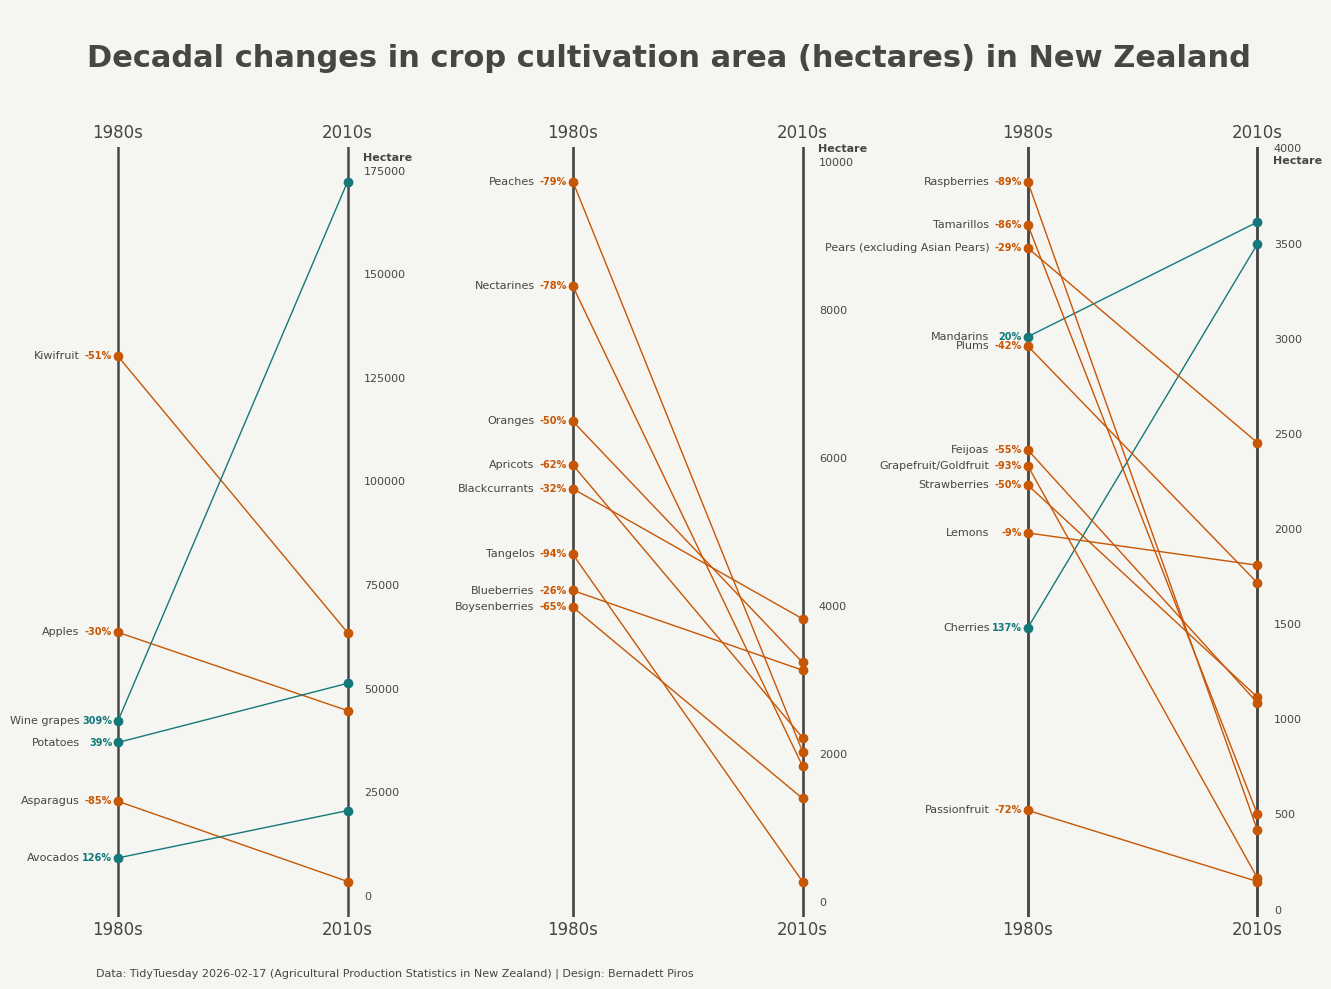

In [21]:
# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
# Adjust vertical space between subplots
plt.subplots_adjust(wspace=0.8)

# List of offsets to adjust "Hectare" label
offsets=[5000, 400, 90]

# Loop through each subplot, df, offset 
for ax, df, offset in zip(axes, dfs, offsets):

    # Aesthetics for the axes
    ax.set_facecolor("#f5f5f1")
    ax.yaxis.tick_right()
    ax.tick_params(axis="y", labelcolor="#464645", labelsize=8, length=0)    
    ax.set_xticks([1980, 2010], labels=["1980s", "2010s"])    
    ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
    ax.tick_params(axis="x", length=0, labelbottom=True, labeltop=True, labelsize=12, labelcolor="#464645")    

    # Add hectare as a measure to the y axis
    ax.text(df["decade"].iloc[1] + 2, df["value"].max() + offset, s="Hectare", color="#464645", size=8, weight="bold")
    
    # Plot slope chart for each dfs
    for measure, temp_df in df.groupby("measure"):

        x = temp_df["decade"]
        y = temp_df["value"]
        color = temp_df["color"].iloc[0]

        ax.plot(x, y, "-o", color=color, markersize=6, lw=1, clip_on=False, zorder=1)

        # Add crop labels
        ax.text(x.iloc[0]-5, y.iloc[0], measure, color="#464645", va="center", ha="right", fontsize=8, clip_on=False)        

        # Add vertical lines
        ax.axvline(x=temp_df["decade"].iloc[0], color="#464645", linestyle="solid", lw=1, zorder=-3) 
        ax.axvline(x=temp_df["decade"].iloc[1], color="#464645", linestyle="solid", lw=1, zorder=-3) 

        # Add percentage label 
        percent_values = temp_df["pct_change"].dropna()        
        ax.text(x.iloc[0] - 0.75, y.iloc[0], f"{percent_values.iloc[-1]:.0f}%", color=color, fontsize=7,
                weight = "bold", ha="right", va="center", clip_on=False)            

# Add background color
fig.set_facecolor("#f5f5f1")

# Title
fig.text(0.5, 0.96, "\nDecadal changes in crop cultivation area (hectares) in New Zealand", color="#464645", fontsize=22, weight="bold",  ha="center")

# Add caption
fig.text(0.118, 0.05, "Data: TidyTuesday 2026-02-17 (Agricultural Production Statistics in New Zealand) | Design: Bernadett Piros", color="#464645", size=8)

plt.show()

# Save figure
#fig.savefig("2026-02-17.png", bbox_inches="tight", pad_inches=0.2)